Make the H5O2 xyz

In [1]:
from nbed.utils import (
    pubchem_mol_geometry,
    build_ordered_xyz_string,
    save_ordered_xyz_file,
)
import numpy as np

water = pubchem_mol_geometry("water")

/Users/michaelwilliamsdelabastida/Library/Caches/pypoetry/virtualenvs/nbed-1_9TTDE1-py3.10/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [2]:
water

{0: ('O', (0, 0, 0)),
 1: ('H', (0.2774, 0.8929, 0.2544)),
 2: ('H', (0.6068, -0.2383, -0.7169))}

In [3]:
h1 = np.array(water[1][1])
h2 = np.array(water[2][1])

In [4]:
av_h_dist = (np.linalg.norm(h1) + np.linalg.norm(h2))/2
av_h_dist

0.9689889756853722

In [5]:
# angle between the two H atoms
h_angle = np.arccos(np.dot(water[1][1], water[2][1])/(np.sqrt(np.sum([w**2 for w in water[1][1]]))*np.sqrt(np.sum([w**2 for w in water[2][1]]))))

In [6]:
hy = av_h_dist*np.sin(h_angle/2)
hx = av_h_dist*np.cos(h_angle/2)

In [7]:
hx, hy

(0.5967028259526409, 0.7634693002995727)

In [8]:
new_water = {0: ('O', (0, 0, 0)), 1: ('H', (-hx, hy, 0)), 2: ('H', (-hx, -hy, 0))} 
new_water

{0: ('O', (0, 0, 0)),
 1: ('H', (-0.5967028259526409, 0.7634693002995727, 0)),
 2: ('H', (-0.5967028259526409, -0.7634693002995727, 0))}

In [9]:
# make a function for setting up 2 water molecules

def two_water_geometry(ox_dist: float, delta: float):
    """
    Args:
    ox_dist: distance between the two oxygen atoms
    delta: proportion of distance between the two oxygen atoms to place the third H atom
    """

    if not (0 < delta < 1):
        raise ValueError("delta must be between 0 and 1")

    full_system = {}
    full_system[0] = new_water[0]
    full_system[1] = new_water[1]
    full_system[2] = new_water[2]

    full_system[3] = ('O', (ox_dist, 0, 0))
    full_system[4] = ('H', (ox_dist - new_water[1][1][0], new_water[1][1][1], 0))
    full_system[5] = ('H', (ox_dist - new_water[2][1][0], new_water[2][1][1], 0))

    full_system[6] = ('H', (ox_dist*delta, 0, 0))

    string_form = "; ".join([f"""{f[0]} {f[1][0]} {f[1][1]} {f[1][2]}""" for f in full_system.values()])

    return string_form
                    

In [ ]:
from pathlib import Path
from pyscf import gto, scf, cc
import ray

@ray.remote
def parallel_energies(o_dist, delta):
        pass_geo = two_water_geometry(o_dist, delta)
        mol = gto.Mole(atom=pass_geo, basis='sto-3g', charge=1)
        mol.build()
        print("NAO: ", mol.nao)

        hf = scf.RHF(mol).run()
        ccsd = cc.CCSD(hf).run()
        return ccsd.e_tot

energies = {}

oo_distances = np.linspace(2, 5, 20)
deltas = np.linspace(0.1, 0.5, 20)

for o_dist in oo_distances:
    energies[o_dist] = []
    for delta in deltas:
        energies[o_dist].append(parallel_energies.remote(o_dist, delta))

energies = ray.get(energies)

In [10]:
from pathlib import Path
from pyscf import gto, scf, cc

energies = {}

oo_distances = np.linspace(2, 5, 20)
deltas = np.linspace(0.1, 0.5, 20)

for o_dist in oo_distances:
    energies[o_dist] = []
    for delta in deltas:
        pass_geo = two_water_geometry(o_dist, delta)
        mol = gto.Mole(atom=pass_geo, basis='sto-3g', charge=1)
        mol.build()

        hf = scf.RHF(mol).run()
        ccsd = cc.CCSD(hf).run()
        energies[o_dist].append(ccsd.e_tot)

print("NAO: ", mol.nao)

converged SCF energy = -141.028622607999
E(CCSD) = -141.1077423298422  E_corr = -0.07911972184348444
converged SCF energy = -143.750196805255
E(CCSD) = -143.8318281270012  E_corr = -0.08163132174598584
converged SCF energy = -145.582404472395
E(CCSD) = -145.6667829627361  E_corr = -0.08437849034123167
converged SCF energy = -146.866631708088
E(CCSD) = -146.9536665266813  E_corr = -0.08703481859372587
converged SCF energy = -147.788306531752
E(CCSD) = -147.8777400060591  E_corr = -0.08943347430668543
converged SCF energy = -148.460016123262
E(CCSD) = -148.5515728829348  E_corr = -0.09155675967310176
converged SCF energy = -148.954775547105
E(CCSD) = -149.048230032028  E_corr = -0.09345448492298866
converged SCF energy = -149.32179876251
E(CCSD) = -149.4169864075328  E_corr = -0.095187645022465
converged SCF energy = -149.595215875336
E(CCSD) = -149.6920226543308  E_corr = -0.09680677899464354
converged SCF energy = -149.799276138071
E(CCSD) = -149.8976231244469  E_corr = -0.098346986376

# Plot the Energy surface as a function of O-O distance and $\delta_{O,H}$

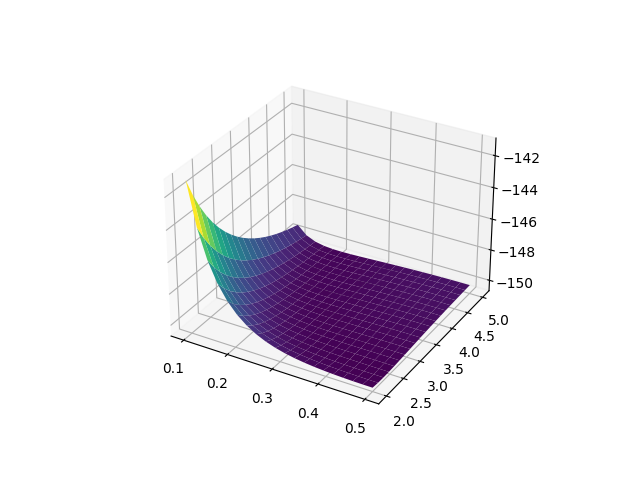

In [11]:
%matplotlib ipympl

x = deltas
y = oo_distances

X, Y = np.meshgrid(x, y)
Z = np.array([e for e in energies.values()])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# 3d plot the surface
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
plt.show()

# Similar plot, but with normalized values to see the double well.

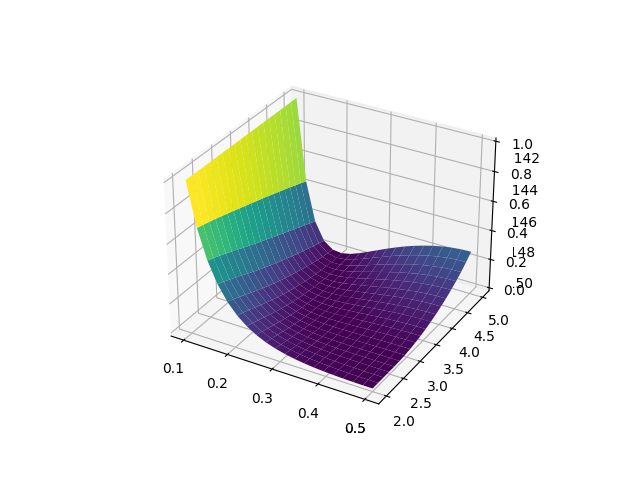

In [12]:
%matplotlib ipympl

x = deltas
y = oo_distances

X, Y = np.meshgrid(x, y)
Z = np.array([(e-np.min(e))/(np.max(e)-np.min(e)) for e in energies.values()])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# 3d plot the surface

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
plt.show()

# Where does the behaviour change from a double well to a single well?

In [13]:
for d, e in energies.items():
    if np.all(np.array(e)[1:]-np.array(e)[:-1] < 0):
        print(f"Single well at distance: {d}")

Single well at distance: 2.0
Single well at distance: 2.1578947368421053
Single well at distance: 2.3157894736842106
Single well at distance: 2.473684210526316


In [14]:
h_angle

1.8147923504529797

In [15]:
Oy = 3*np.sin(h_angle/2)
Ox = 3*np.cos(h_angle/2)
o1_os = Oy, Ox

In [16]:
h1_pos = np.sqrt(3**2 + av_h_dist**2)*np.sin(h_angle/2), np.sqrt(3**2 + av_h_dist**2)*np.cos(h_angle/2)

In [17]:
# distance from h1 to o1
h1_o1 = np.sqrt((h1_pos[0] - o1_os[0])**2 + (h1_pos[1] - o1_os[1])**2)
h1_o1

0.1526083859242315

In [18]:
def hydronium_geometry(ox_dist: float, delta: float):
    """
    Args:
    ox_dist: distance between the two oxygen atoms
    delta: proportion of distance between the two oxygen atoms to place the third H atom
    """

    if not (0 < delta < 1):
        raise ValueError("delta must be between 0 and 1")

    full_system = {}
    full_system[0] = new_water[0]
    full_system[1] = new_water[1]
    full_system[2] = new_water[2]

    full_system[3] = ('O', (ox_dist, 0, 0))
    full_system[4] = ('H', (ox_dist - new_water[1][1][0], new_water[1][1][1], 0))
    full_system[5] = ('H', (ox_dist - new_water[2][1][0], new_water[2][1][1], 0))

    full_system[6] = ('H', (ox_dist*delta, 0, 0))

    o1x = -2.363708936191661
    o1y = 1.8473981879843033
    h_dist = 0.9689889756853722

    full_system[7] = ('O', (o1x, o1y, 0))
    full_system[8] = ('H', (o1x - h_dist, o1y, 0))
    full_system[9] = ('H', (o1x + h_dist*np.cos(np.pi-h_angle), o1y + h_dist*np.sin(np.pi - h_angle), 0))

    full_system[10] = ('O', (o1x, -o1y, 0))
    full_system[11] = ('H', (o1x - h_dist, -o1y, 0))
    full_system[12] = ('H', (o1x + h_dist*np.cos(np.pi-h_angle), -o1y - h_dist*np.sin(np.pi - h_angle), 0))

    string_form = "\n".join([f"""{f[0]}\t{f[1][0]}\t{f[1][1]}\t{f[1][2]}""" for f in full_system.values()])

    return full_system, string_form

In [19]:
from nbed.utils import (
    pubchem_mol_geometry,
    build_ordered_xyz_string,
    save_ordered_xyz_file,
)

hgeo, hgeostring = hydronium_geometry(3, 0.5)
hgeo_ordered_string = build_ordered_xyz_string(dict(hgeo), [0,3,6])

In [20]:
# from pathlib import Path
# from pyscf import gto, scf, cc

# hydronium_energies = {}

# oo_distances = np.linspace(2, 5, 20)
# deltas = np.linspace(0.1, 0.5, 20)

# for o_dist in oo_distances:
#     hydronium_energies[o_dist] = []
#     for delta in deltas:
#         _, pass_geo = hydronium_geometry(o_dist, delta)
#         mol = gto.Mole(atom=pass_geo, basis='sto-3g', charge=1)
#         mol.build()

#         hf = scf.RHF(mol).run()
#         ccsd = cc.CCSD(hf).run()
#         hydronium_energies[o_dist].append(ccsd.e_tot)

# print("NAO: ", mol.nao)

In [21]:
# %matplotlib ipympl

# x = deltas
# y = oo_distances

# X, Y = np.meshgrid(x, y)
# Z = np.array([e for e in hydronium_energies.values()])

# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# # 3d plot the surface
# ax = plt.axes(projection='3d')
# ax.plot_surface(X, Y, Z, cmap='viridis')
# plt.show()

In [22]:
# %matplotlib ipympl

# x = deltas
# y = oo_distances

# X, Y = np.meshgrid(x, y)
# Z = np.array([(e-np.min(e))/(np.max(e)-np.min(e)) for e in hydronium_energies.values()])

# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# # 3d plot the surface

# ax = plt.axes(projection='3d')
# ax.plot_surface(X, Y, Z, cmap='viridis')
# plt.show()

In [23]:
from nbed.driver import NbedDriver

args = {
    "geometry": hgeo_ordered_string,
    "n_active_atoms": 3,
    "basis": "sto-3g",
    "xc_functional": "b3lyp",
    "projector": "both",
    "localization": "spade",
    "convergence": 1e-6,
    "max_ram_memory": 8_000,
    "charge":1,
    "spin":0,
}

driver = NbedDriver(**args)

Initialize <pyscf.gto.mole.Mole object at 0x2bf0d7b80> in <pyscf.dft.rks.RKS object at 0x2bf0d7c10>
Initialize <pyscf.gto.mole.Mole object at 0x2bf0d7c10> in <pyscf.dft.rks.RKS object at 0x2bf0d7e80>
2024-04-29 13:16:43,892: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


In [59]:
from qiskit_nature.second_q.operators import FermionicOp
from qiskit.quantum_info import Pauli, SparsePauliOp

import numpy as np
from math import ceil, log2
from copy import copy 

def num2binstr(n):
    return bin(n)[2:]

def lowbit(x):
    return x & (-x)

def generate_perms(n, until): 
    """
    (a math tool)
    Return a list of numbers with `n` ones in their binary expressions in ascending order. 
    The last element in the list does not exceed `until`.
    
    Args:
        n (int) : number of ones
        until (int) : upper bound of list elements
    
    Returns:
        ([Int]) : the generated list
    """
    a = 2 ** n - 1
    perms = [num2binstr(a)]
    while(True):
        a = a + lowbit(a) + lowbit(1 + a // lowbit(a)) // 2 - 1
        if (a > until):
            break
        else:
            perms.append(num2binstr(a))
            
    max_length = len(perms[-1])
    perms = list(map(lambda s: ('0' * (max_length - len(s)) + s), perms))
    return perms

def all_config(num_so, num_e): 
    until = 2 ** (num_so) - 1
    n = num_e
    configs = []
    for i in generate_perms(n, until):
        configs.append(i)
    return configs


def default_labeling(configs):
    q2o = {}  ## qubit label to occupation numbers
    o2q = {}  ## occupation numbers to qubit label
    num_qubits = ceil(log2(len(configs)))
    for idx, config in enumerate(configs):
        q_label = '0' * (num_qubits - len(num2binstr(idx))) + num2binstr(idx)
        q2o[q_label] = config
        o2q[config] = q_label
    return q2o, o2q

def reverse_labeling(configs):
    q2o = {}  ## qubit label to occupation numbers
    o2q = {}  ## occupation numbers to qubit label
    num_qubits = ceil(log2(len(configs)))
    for idx, config in enumerate(configs):
        idx = 2**num_qubits - idx -1
        q_label = '0' * (num_qubits - len(num2binstr(idx))) + num2binstr(idx)
        q2o[q_label] = config
        o2q[config] = q_label
    return q2o, o2q

def possible_excitations(num_so):
    excitations = set()
    for i in range(num_so):
        for j in range(i+1):
            excitations.add((i, j))
    return excitations


def label2Pauli(s):
    """
    Convert a Pauli string into Pauli object. 
    Note that the qubits are labelled in descending order: 'IXYZ' represents I_3 X_2 Y_1 Z_0
    
    Args: 
        s (str) : string representation of a Pauli term
    
    Returns:
        qiskit.quantum_info.Pauli: Pauli object of s
    """
    
    xs = []
    zs = []
    label2XZ = {'I': (0, 0), 'X': (1, 0), 'Y': (1, 1), 'Z': (0, 1)}
    for c in s[::-1]:
        x, z = label2XZ[c]
        xs.append(x)
        zs.append(z)
    return Pauli(z = zs, x = xs)


def get_entry_operators(num_so, num_e, labeling_method, mode):
    """
        Entry-operators are tensor products of some of the following operators: ['+', '-', '1', '0']. 
        '+' and '-' are qubit creation/annihilation operators, respectively. 
        '1' and '0' are counting operators for qubit state 1 and 0, respectively.
        Note that '+' = (X-iY)/2, '-' = (X+iY)/2, '1' = (I-Z)/2, '0' = (I+Z)/2.

        This function considers all possible excitations and calculates corresponding excitation oprators
        in terms of entry-operators. 

        Args:
            num_so (int) : Number of spin-orbitals(must be even).
            num_e (int) : Number of electrons(must be even).
            labeling_method (function) : 
                It maps each electron occupation configuration to a qubit computational basis state.
                By default it uses `default_labeling` method. 
                If it is set to `None`, default method will be used. 
                Please make sure that the input/output types match that of the `default_labeling` function.
        Returns:
            (tuple(int, dict(tuple(int, int), list(tuple(float, str))))):
                First nubmer in the tuple is total required number of qubits. 
                The second element is the mapping dictionary whose keys are indices of excitations
                ((i, j)->'a_i^ a_j'), and its values are list of entry-operators(str) with corresponding
                coefficients(float).

    """
    hopping_in_entry = {('0', '0'): '0',
                        ('1', '1'): '1',
                        ('0', '1'): '+',
                        ('1', '0'): '-'} ## (from, to)
    if mode == 'rhf':
        mapping = {}
        configs = all_config(num_so // 2, num_e // 2)
        half_qubits = int(ceil(log2(len(configs))))
        q2o, o2q = labeling_method(configs)
        excitations = possible_excitations(num_so // 2)

        def dual(s):
            return s[half_qubits:] + s[:half_qubits]

        for i, j in excitations:
            mapping[(i, j)] = []
            mapping[(i + num_so//2, j + num_so//2)] = []
            for c in configs:
                N = len(c)
                creation = N - i - 1
                annihilation = N - j - 1
                if c[creation] == '0' and c[annihilation] == '1':
                    hopped_c = c[: creation] + '1' + c[creation + 1 : annihilation] + '0' + c[annihilation + 1 :]
                    parity = 1 - 2 * (sum([int(i) for i in c[creation + 1 : annihilation]]) % 2)
                    entry_op = ''
                    for q0, q in zip(o2q[c], o2q[hopped_c]):
                        entry_op += hopping_in_entry[(q0, q)]
                    entry_op += ('I' * half_qubits) 
                    mapping[(i, j)].append((parity, entry_op))
                    mapping[(i + num_so//2, j + num_so//2)].append((parity, dual(entry_op)))
                elif creation == annihilation and c[creation] == '1':
                    entry_op = ''
                    for q in o2q[c]: 
                        entry_op += hopping_in_entry[(q, q)]
                    entry_op += ('I' * half_qubits)
                    mapping[(i, j)].append((1, entry_op))
                    mapping[(i + num_so//2, j + num_so//2)].append((1, dual(entry_op)))
        return 2 * half_qubits, mapping

    if mode == 'uhf' or mode == 'stacked_rhf':
        if mode == 'uhf':
            configs = all_config(num_so, num_e)
            excitations = possible_excitations(num_so)
        else :
            sub_configs = all_config(num_so // 2, num_e // 2)
            configs = []
            for i in sub_configs:
                for j in sub_configs:
                    configs.append(i + j)
            excitations = possible_excitations(num_so // 2)
            for p, q in excitations.copy():
                excitations.add((p + num_so // 2, q + num_so // 2))

        mapping = {}
        num_qubits = int(ceil(log2(len(configs))))
        q2o, o2q = labeling_method(configs)
        
        for i, j in excitations:
            mapping[(i, j)] = []
            for c in configs:
                N = len(c)
                creation = N - i - 1
                annihilation = N - j - 1
                if c[creation] == '0' and c[annihilation] == '1':
                    hopped_c = c[: creation] + '1' + c[creation + 1 : annihilation] + '0' + c[annihilation + 1 :]
                    parity = 1 - 2 * (sum([int(i) for i in c[creation + 1 : annihilation]]) % 2)
                    entry_op = ''
                    for q0, q in zip(o2q[c], o2q[hopped_c]):
                        entry_op += hopping_in_entry[(q0, q)]
                    mapping[(i, j)].append((parity, entry_op))
                elif creation == annihilation and c[creation] == '1':
                    entry_op = ''
                    for q in o2q[c]: 
                        entry_op += hopping_in_entry[(q, q)]
                    mapping[(i, j)].append((1, entry_op))
        return num_qubits, mapping


def operator2labels(operators_with_coef, index=0, num_qubits=0):
    # terminate the recursion when the pointer position (index) is larger than the length of the operator
    if index == num_qubits:
        return operators_with_coef
    # the matrix here means X, Y, Z, I, 0, 1, +, - at the specified pointer position (index)
    matrix = operators_with_coef[0][1][index]
    # go to the next loop when there's no 0, 1, +, - at the specified position
    if matrix in ['X', 'Y', 'Z', 'I']:
        return operator2labels(operators_with_coef, index+1, num_qubits)
    # define a new [coef, operator] list so that each of the [coef, operator] pair can be
    # separated into two terms with pauli matrix representation at the specified position
    new_operators_with_coef = []
    if matrix == '0':
        for [coef, operator] in operators_with_coef:
            first_op = operator[:index] + 'I' + operator[index+1:]
            second_op = operator[:index] + 'Z' + operator[index+1:]
            new_operators_with_coef.append([0.5*coef, first_op])
            new_operators_with_coef.append([0.5*coef, second_op])
    elif matrix == '1':
        for [coef, operator] in operators_with_coef:
            first_op = operator[:index] + 'I' + operator[index+1:]
            second_op = operator[:index] + 'Z' + operator[index+1:]
            new_operators_with_coef.append([0.5*coef, first_op])
            new_operators_with_coef.append([-0.5*coef, second_op])
    elif matrix == '+':
        for [coef, operator] in operators_with_coef:
            first_op = operator[:index] + 'X' + operator[index+1:]
            second_op = operator[:index] + 'Y' + operator[index+1:]
            new_operators_with_coef.append([0.5*coef, first_op])
            new_operators_with_coef.append([-0.5j*coef, second_op])
    elif matrix == '-':
        for [coef, operator] in operators_with_coef:
            first_op = operator[:index] + 'X' + operator[index+1:]
            second_op = operator[:index] + 'Y' + operator[index+1:]
            new_operators_with_coef.append([0.5*coef, first_op])
            new_operators_with_coef.append([0.5j*coef, second_op]) 
    return operator2labels(new_operators_with_coef, index+1, num_qubits)


# add the `coef` parameter
import ray 
@ray.remote
def operator2SparsePauliOp(operator, coef=1, num_qubits=None):
    pauli_labels = operator2labels([[coef, operator]], num_qubits=num_qubits)
    coeffs = [c for (c, l) in pauli_labels]
    labels = [l for (c, l) in pauli_labels]
    return SparsePauliOp(data=labels, coeffs=coeffs)

def get_naive_mapping_from_entry(entry_operators, num_qubits=None):
    """
    Get the naive mapping from a given entry_operator dictionary 

    Returns:
        naive_mapping (dict((tuple(int, int)), qiskit.quantum_info.Pauli)): 
            mapping, which should be passed into `complete_mapping`, 
            from some of the allowed a_p^ a_q to Pauli operator
    """
    # naive_mapping = {}
    # for (i, j) in entry_operators.keys():
    #     for (coef, operator) in entry_operators[(i, j)]:
    #         if (i, j) not in naive_mapping:
    #             naive_mapping[(i, j)] = operator2SparsePauliOp(operator, coef, num_qubits)
    #         else:
    #             naive_mapping[(i, j)] += operator2SparsePauliOp(operator, coef, num_qubits)
    # return naive_mapping

    @ray.remote
    def map_ij(i,j, num_qubits=None):
        mapping = None

        def operator2SparsePauliOp(operator, coef=1, num_qubits=None):
            pauli_labels = operator2labels([[coef, operator]], num_qubits=num_qubits)
            coeffs = [c for (c, l) in pauli_labels]
            labels = [l for (c, l) in pauli_labels]
            return SparsePauliOp(data=labels, coeffs=coeffs)
        results = [operator2SparsePauliOp(operator, coef, num_qubits) for (coef, operator) in entry_operators[(i, j)]]
        for op in results:
            if mapping is None:
                mapping = op
            else:
                mapping += op
        return (i,j), mapping

    naive_mapping = {}
    results = [map_ij.remote(i,j, num_qubits) for (i, j) in entry_operators.keys()]
    mappings = ray.get(results)
    for mapping in mappings:
        i, j = mapping[0]
        op = mapping[1]
        if (i, j) not in naive_mapping:
            naive_mapping[(i, j)] = op
        else:
            naive_mapping[(i, j)] += op

    return naive_mapping

def complete_mapping(naive_mapping):
    mapping = copy(naive_mapping)
    for k, w in naive_mapping.items():
        k1, k2 = k
        if (k1 != k2) and ((k2, k1) not in naive_mapping.keys()):
            new_k = (k2, k1)
            paulis = list(map(lambda x: [np.conj(x[0]), x[1]], w.paulis))
            mapping[new_k] = SparsePauliOp(paulis)
    return mapping

def fermionic2QubitMapping(num_so, num_e, labeling_method = default_labeling, mode = 'rhf'):
    """
        Generate qubit mapping for given number of spin-orbitals and electrons 
        based on certain labeling method(from occupation configurations to qubit states).

        Args:
            num_so (int) : Number of spin-orbitals, must be even as we only consider RHF configuration.
            num_e (int) : Number of electrons, must be even.
            labeling_method (function) : 
                It maps each electron occupation configuration to a qubit computational basis state.
                By default it uses `default_labeling` method. 
                If it is set to `None`, default method will be used. 
                Please make sure that the input/output types match that of the `default_labeling` function.

        Returns:
            (dict(tuple(int, int), SparsePauliOp)) : 
                A dictionary whose keys are indices of excitation operators((i, j)->'a_i^ a_j') 
                and values are corresponding Pauli operators(SparsePauliOp).
                
    """
    if labeling_method == None: labeling_method = default_labeling
    print("getting entry operators")
    num_qubits, entry_operators = get_entry_operators(num_so, num_e, labeling_method, mode)
    print("getting naive mapping")
    naive_mapping = get_naive_mapping_from_entry(entry_operators, num_qubits)
    print("completing mapping")
    mapping = complete_mapping(naive_mapping)
    return mapping

In [60]:
from qiskit_nature.second_q.operators import FermionicOp
from qiskit.quantum_info import Pauli 

import numpy as np
from concurrent.futures import ProcessPoolExecutor


def kDelta(i, j):
    return 1 * (i == j)

def label2Pauli(s):
    """
    Convert a Pauli string into Pauli object. 
    Note that the qubits are labelled in descending order: 'IXYZ' represents I_3 X_2 Y_1 Z_0
    
    Args: 
        s (str) : string representation of a Pauli term
    
    Returns:
        qiskit.quantum_info.Pauli: Pauli object of s
    """
    
    xs = []
    zs = []
    label2XZ = {'I': (0, 0), 'X': (1, 0), 'Y': (1, 1), 'Z': (0, 1)}
    for c in s[::-1]:
        x, z = label2XZ[c]
        xs.append(x)
        zs.append(z)
    return Pauli(z = zs, x = xs)


class groupedFermionicOperator:
    """
    An alternative representation (grouped-operator form) of `qiskit.chemistry.FermionicOperator`.
    Two-electron terms (a_p^ a_q^ a_r a_s) are rearranged into products of (a_i^ a_j).
    (a_n^, a_n are creation and annihilation operators, respectively, acting on the n-th qubit.)
    """
    def __init__(self, ferOp, num_electron, labeling_method=None, mode='rhf'):
        """
        This class rewrites a `FermionicOperator` into a grouped-operator form stored in `self.grouped_op`.
        The `self.grouped_op` is a dictionary containing information of all one- and two-electron terms.
        For a one-electron term h_pq=val, it is stored as {(p, q): val}.
        For a two-electron term h_pqrs=val, it is first decomposed into products of one-electron terms,
            e.g. a_p^ a_q^ a_r a_s = kDelta(q, r) * (a_p^ a_s) - (a_p^ a_r) * (a_q^ a_s).
        In case (p, r) is not an allowed transition(due to spin restrictions etc), a_r and a_s 
        can be exchanged with an extra minus sign (handled by `parity` in the code.)
        Finally, all two-electron terms can be decomposed into products of ALLOWED one-electron terms.
        
        The `mapping` is used to convert fermionic operators into qubit operators(typically Pauli terms).
        It is a dictionary whose keys are indices of allowed transitions (e.g. (p, q) if a_p^ a_q is allowed) 
        and values are the Pauli term corresponding to a_p^ a_q.
        
        Args:
            ferOp (qiskit.chemistry.FermionicOperator): second-quantized fermionic operator
            num_electron (int): number of electron in the system
            labeling_method (function):
                It maps each electron occupation configuration to a qubit computational basis state.
                (Please refer to docString of fermionic2QuantumMapping for details)
            mode (str): it should be either 'rhf' or 'uhf'.
                'rhf' mode:
                    Same number of spin-up and spin-down electrons. 
                    Their configurations are encoded to qubits independently.
                    (# of qubits = 2 * (ceil(log2(num_of_config(num_electron/2)))))
                'stacked_rhf' mode:
                    Same number of spin-up and spin-down electrons.
                    All allowed configurations are encoded together
                    (# of qubits = ceil(2 * log2(num_of_config(num_electron/2))))
                'uhf' mode:
                    No restriction on spin conservation. All configuration are encoded to qubits.
                    (# of qubits = ceil(log2(num_of_config(num_electron))))
        """
        self.grouped_op = {}
        self.THRESHOLD = 1e-6
        self.mapping = fermionic2QubitMapping(num_so = ferOp.num_spin_orbitals,
                                             num_e = num_electron, 
                                             labeling_method = labeling_method,
                                             mode = mode)
        self.set_ferOp(ferOp)
        # h1, h2 = np.copy(ferOp.h1), np.copy(ferOp.h2)
        # it1 = np.nditer(h1, flags=['multi_index'])
        # it2 = np.nditer(h2, flags=['multi_index'])
        # for h in it1:
        #     key = it1.multi_index
        #     self._add_an_h1(h, key)
        # for h in it2:
        #     key = it2.multi_index
        #     self._add_an_h2(h, key)

    def set_ferOp(self, ferOp):
        h1, h2 = np.copy(ferOp.h1), np.copy(ferOp.h2)
        it1 = np.nditer(h1, flags=['multi_index'])
        it2 = np.nditer(h2, flags=['multi_index'])
        for h in it1:
            key = it1.multi_index
            self._add_an_h1(h, key)
        for h in it2:
            key = it2.multi_index
            self._add_an_h2(h, key)
        
    def _add_an_h1(self, coef, pq):
        """
            Add a single one-electron term into the grouped operator.  
            
            Args:
                coef (complex) : value of one-electron integral
                pq (tuple(int, int)): index of the one-electron term
        """
        if(abs(coef) < self.THRESHOLD): return 
        if pq in self.grouped_op.keys():
            self.grouped_op[pq] = self.grouped_op[pq] + coef
        else:
            self.grouped_op[pq] = coef
    
    def _add_an_h2(self, coef, pqrs):
        """
            Add a single two-electron term into the grouped operator. 
            
            Args:
                coef (complex) : value of two-electron integral
                pqrs (tuple(int, int, int, int)): index(in chemist notation) of the two-electron term
        """
        if(abs(coef) < self.THRESHOLD): return 
        parity = 1
        
        ## Note that in FermionicOperator, index (p,q,r,s) represents a_p^ a_r^ a_s a_q: chemist notation
        ## Here I use (p,q,r,s) to represent a_p^ a_q^ a_r a_s: physicist notation
        ## Thus the re-ordering of h-indices is needed
        p, s, q, r = pqrs

        ## Handle the exchange of a_r a_s if direct transformation will give illegal transitions
        if (((p, r) not in self.mapping.keys()) and ((r,p) not in self.mapping.keys())):
            r, s = s, r
            parity = -1
            print('Change to:', (p,q,r,s))
            
        ## a_p^ a_q^ a_r a_s = kDelta(q, r) * (a_p^ a_s) - (a_p^ a_r) * (a_q^ a_s)
        self._add_an_h1(parity * coef * kDelta(q, r), (p, s))
        mut_key = ((p, r), (q, s))
        if mut_key in self.grouped_op.keys():
            self.grouped_op[mut_key] -= coef * parity
        else:
            self.grouped_op[mut_key] = -coef * parity
    
    def get_qubit_Op(self, group_op_items):
        """
        Get qubit operator from the transition and weights from group operators. A helper function of to_paulis
            Args:
                    group_op_items (group-operator form) : a partial list of key-value pairs from self.group_op

            Returns:
                    (qiskit.aqua.operators.SparsePauliOp) : qubit operator transformed based on `self.mapping`
        """
        print("One Processor Processing...")
        mapping = self.mapping
        qubitOp = SparsePauliOp(paulis=[])
        for k, w in group_op_items:
            if np.ndim(k) == 1:  ## one-e-term
                qubitOp += (w * mapping[k])
            elif np.ndim(k) == 2:  ## 2-e-term
                k1, k2 = k
                qubitOp += (w * mapping[k1] * mapping[k2])
            else:
                raise ValueError('something wrong')
        print("One Processor Done...")
        return qubitOp

    def to_paulis(self, cpu_count=1):
        """
        Convert the grouped fermionic operator into qubit operators (sum of Pauli terms)
            Args:
                    cpu_count (int) : number of CPUs (processes) to handle this function

            Returns:
                    (qiskit.aqua.operators.SparsePauliOp) : qubit operator transformed based on `self.mapping`
        """
        if cpu_count == 1:
            mapping = self.mapping
            qubitOp = SparsePauliOp(paulis=[])

            for k, w in self.grouped_op.items():
                if np.ndim(k) == 1: ## one-e-term
                    qubitOp += (w * mapping[k])
                elif np.ndim(k) == 2: ## 2-e-term
                    k1, k2 = k
                    qubitOp += (w * mapping[k1] * mapping[k2])
                else:
                    raise ValueError('something wrong')
            qubitOp.chop(threshold=self.THRESHOLD)
        elif cpu_count > 1:
            arguments = []
            group_op_items_per_cpu = len(self.grouped_op.items()) // cpu_count + 1
            prev = 0
            for i in range(cpu_count):
                if i == cpu_count - 1:
                    arguments.append(list(self.grouped_op.items())[prev:])
                    break
                end = group_op_items_per_cpu * (i + 1)
                arguments.append(list(self.grouped_op.items())[prev:end])
                prev = end
            with ProcessPoolExecutor() as executor:
                results = executor.map(self.get_qubit_Op, arguments)
                qubitOp = SparsePauliOp(paulis=[])
                for result in results:
                    qubitOp += result
            qubitOp.chop(threshold=self.THRESHOLD)
        else:
            raise ValueError('CPU count has to be greater or equal to 1')
        return qubitOp

In [61]:
from qiskit_nature.second_q.operators import ElectronicIntegrals

In [62]:
driver.embedded_scf[0].mo_occ

array([array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
              0., 0.])                                                           ,
       array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
              0., 0.])                                                           ],
      dtype=object)

In [63]:
[*range(2, 17)]

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [64]:
from nbed.ham_builder import HamiltonianBuilder

hb = HamiltonianBuilder(driver.embedded_scf[0])
core_constant, one_body, two_body = hb._reduce_active_space(hb._one_body_integrals, 
                                                            hb._two_body_integrals, 
                                                            [0,1], [*range(2, 17)])

ei_object = ElectronicIntegrals.from_raw_integrals(h1_a=one_body[0],
                                       h2_aa = two_body[0],
                                       h1_b = one_body[1],
                                       h2_bb = two_body[1],
                                       h2_ba = two_body[3])

fermion_op = FermionicOp.from_polynomial_tensor(ei_object.second_q_coeffs())


Try doing a reduction using HamiltonianBuilder
- get reduced one and two body integrals

In [65]:
gfop = groupedFermionicOperator(fermion_op, sum(driver.embedded_scf[0].nelec), mode='rhf')

getting entry operators
getting naive mapping
